*отчет подготовила Гущина Вера 08.08.2025*

# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### Работа с историческими данными (EDA)

#### Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from math import ceil
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest

<div class="alert alert-block alert-success">

**Комментарий ревьювера (все отлично)**
    
Правильно, что импортируешь необходимые библиотеки в первой ячейке. Так твой коллега, запускающий работу, будет в курсе используемых в ней библиотек и сможет настроить свое окружение при необходимости.
</div>

In [2]:
# создадим датафрейм sessions_history с историческими данными о сессиях пользователей sessions_project_history.csv
sessions_history=pd.read_csv('/datasets/sessions_project_history.csv')
# выведем на экран первые пять строк полученного датафрейма
display(sessions_history.head(5))

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


####  Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [3]:
# расчитаем количество уникальных сессий для каждого пользователя
sessions_history_grp = (
    sessions_history
    .groupby(['user_id'])
    .agg({
        'session_id': 'nunique',
    })
    .sort_values(by='session_id', ascending=False) # отсортируем в порядке убывания
    .reset_index()
)

In [4]:
# оставим данные о пользователе с наибольшим количеством сессий
sessions_history_example = sessions_history_grp.head(1) 

In [5]:
# выведем данные о сессиях пользователя
display(sessions_history[sessions_history['user_id'].isin(sessions_history_example['user_id'])])

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


####  Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

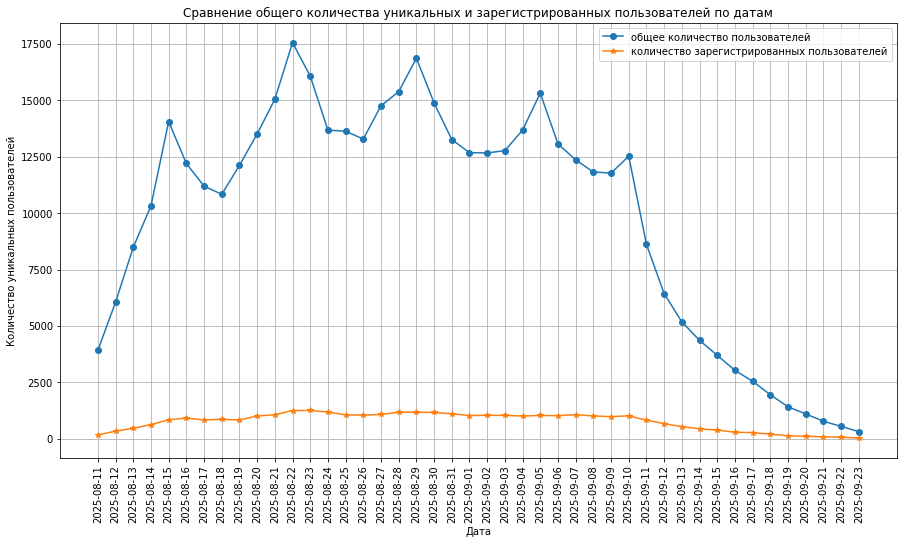

In [6]:
# построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням
# посчитаем количество уникальных пользователей в день
df_sessions_history = (
    sessions_history
    .groupby(['session_date'])
    .agg({
        'user_id': 'nunique',
    })
    .reset_index()
)

# посчитаем количество уникальных зарегистрированных пользователей в день
df_grp = (
    sessions_history
    .groupby(['session_date','registration_flag'])
    .agg({
        'user_id': 'nunique',
    })
    .reset_index()
)
# построим графики
x = df_sessions_history.session_date.unique()
y_a = df_sessions_history.user_id
y_b = df_grp[df_grp.registration_flag==1].user_id

plt.figure(figsize=(15, 8))
plt.plot(x, y_a, marker='o', label ='общее количество пользователей')
plt.plot(x, y_b,marker='*', label ='количество зарегистрированных пользователей')

plt.xlabel("Дата")
plt.xticks(rotation=90)
plt.ylabel("Количество уникальных пользователей")
plt.legend()
plt.title('Сравнение общего количества уникальных и зарегистрированных пользователей по датам')
plt.grid (True)
plt.show()

Начиная с 2025-09-11 наблюдается резкий спад количества пользователей. Линии графиков общего количества уникальных и зарегистрированных пользовтелей сближаются.

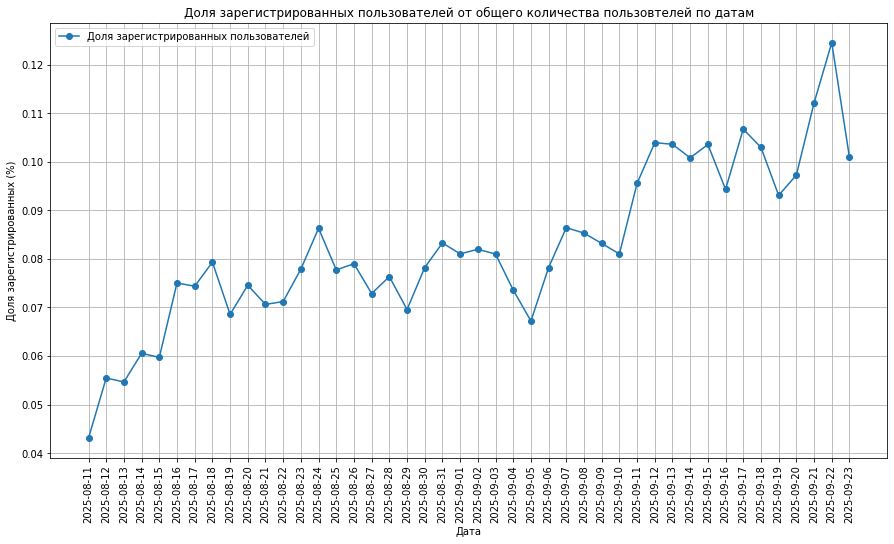

In [7]:
# построим график доли зарегистрированных пользователей от всех пользователей по дням
x = df_sessions_history['session_date']
y_a = df_sessions_history['user_id']  # Общее количество уникальных пользователей
y_b = df_grp[df_grp['registration_flag'] == 1]['user_id'].values  # Зарегистрированные пользователи

# вычислим долю зарегистрированных пользовтелей
percentage_registered = y_b / y_a

# построим график
plt.figure(figsize=(15, 8))
plt.plot(x, percentage_registered, marker='o', label='Доля зарегистрированных пользователей')
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.ylabel('Доля зарегистрированных (%)')
plt.title('Доля зарегистрированных пользователей от общего количества пользовтелей по датам')
plt.legend()
plt.grid(True)
plt.show()

Доля зарегистрированных пользовтелей постепенно растет, однако в последний наблюдаемый день показатель падает.

#### Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29 160 сессиях, две страницы — в 105 536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

In [8]:
# найдем количество сессий для каждого значения количества просмотренных страниц
df_pages = (
    sessions_history
    .groupby(['page_counter'])
    .agg({
        'session_id': 'nunique',
    })
    .reset_index()
)
display(df_pages)

,page_counter,session_id
0,1,29160
1,2,105536
2,3,166690
3,4,105569
4,5,26288
5,6,2589
6,7,92


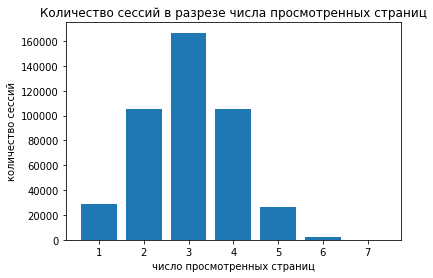

In [9]:
# построим столбчатую диаграмму
x = df_pages['page_counter']
y = df_pages['session_id'].values
             
plt.bar(x, y)
plt.xlabel('число просмотренных страниц')
plt.ylabel('количество сессий')
plt.title('Количество сессий в разрезе числа просмотренных страниц')
plt.show()

Чаще всего пользоввтели просматривают 3 страницы за сессию.

####  Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

In [10]:
# создадим новый столбец, заполним его значением 0
sessions_history['good_session']=0
# при выполнении условия "количество сессий >= 4" заполним значением 1
sessions_history.loc[sessions_history['page_counter'] >= 4, 'good_session'] = 1 

In [11]:
# создадим датафрейм
df_successful_sessions = (
    sessions_history
    .groupby(['session_date'])
    .agg({
        'session_id': 'count',
        'good_session': 'sum',
    })
    .reset_index()
)

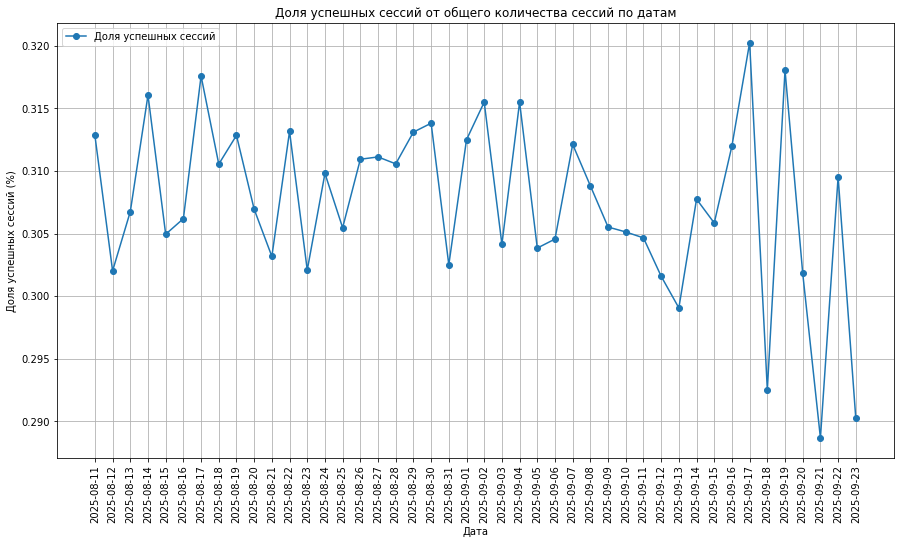

In [12]:
# построим график доли успешных сессий от количества всех сессий по дням
x = df_successful_sessions['session_date']
y_a = df_successful_sessions['session_id']  # Общее количество сессий
y_b = df_successful_sessions['good_session']  # Количество успешных сессий

# вычислим долю успешных сессий
percentage_successful_sessions = y_b / y_a

# построим график
plt.figure(figsize=(15, 8))
plt.plot(x, percentage_successful_sessions, marker='o', label='Доля успешных сессий')
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.ylabel('Доля успешных сессий (%)')
plt.title('Доля успешных сессий от общего количества сессий по датам')
plt.legend()
plt.grid(True)
plt.show()

На основании текущего графика не представляется возможным сказать о каких-либо тенденциях. Доля сессий, в которых пользователи просматривали 4 сраницы, варитруется в значениях от 0.289 до 0.320.

### Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

####  Формулировка нулевой и альтернативной гипотез

Перед тем как проводить А/B-тест, необходимо сформулировать нулевую и альтернативную гипотезы. Напомним изначальное условие: команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать более интересный контент для каждого пользователя.

О какой метрике идёт речь? Как она будет учтена в формулировке гипотез?

***Метрика: доля успешных сессий (успешной признается сессия, где количество просматриваемых страниц 4 и более (page_counter) за сессию). Новый алгоритм рекомендаций увеличит долю успешных сессий, что увеличит вероятность регистрации пользователя и оплаты подписки.*** 

Сформулируйте нулевую и альтернативную гипотезы:






***Н0: новый алгоритм рекомендаций не оказывает статистически значимого влияния на показатель пользовательской активности (доля успешных сессий не увеличится) по сравнению с существующим алгоритмом.***

***Н1: новый алгоритм рекомендаций увеличит показатель пользовательской активности (доля успешных сессий увеличится) по сравнению с существующим алгоритмом.***

#### Расчёт размера выборки
В рамках курса вы уже рассчитывали размеры выборки и  использовали для этого онлайн-калькулятор. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки используйте метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [13]:
# зададим параметры 
alpha = 0.05  # уровень значимости
beta = 0.2  # ошибка второго рода, часто 1 - мощность
power = 0.8  # мощность теста
p = 0.3 # базовый уровень доли
mde = 0.03 * p  # минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [14]:
# среднее количество пользователей приложения в день по историческим данным
avg_daily_users = ceil(
    sessions_history
    .groupby(['session_date'])
    .agg({
        'user_id': 'nunique',
    })
    .mean()['user_id']
)

# рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(2*sample_size/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9908 пользователей в день составит 9 дней


### Мониторинг А/В-теста

####  Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой будет видно возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [15]:
# считаем и сохраним в датафрейм sessions_test_part CSV-файл с историческими данными о сессиях пользователей sessions_project_test_part.csv
sessions_test_part=pd.read_csv('/datasets/sessions_project_test_part.csv')
# выведем для ознакомления несколько строк
display(sessions_test_part.head(5))

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [16]:
# создадим датафрейм с количеством уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения
df_test_group = (
    sessions_test_part
    .groupby(['test_group'])
    .agg({
        'user_id': 'nunique',
    })
    .reset_index()
)
display(df_test_group)

,test_group,user_id
0,A,1477
1,B,1466


In [17]:
# рассчитаем и выведем на экран процентную разницу в количестве пользователей в группах A и B
# посчитаем количество пользователей в группе А
a_count=df_test_group[df_test_group['test_group']=='A']['user_id'].values
# посчитаем количество пользователей в группе В
b_count=df_test_group[df_test_group['test_group']=='B']['user_id'].values
# расчитаем процентную разницу
p=(a_count-b_count)/a_count*100
print(f"Процентная разница в количестве пользователей в группах A и B: {round(float(p),2)}%")

Процентная разница в количестве пользователей в группах A и B: 0.74%


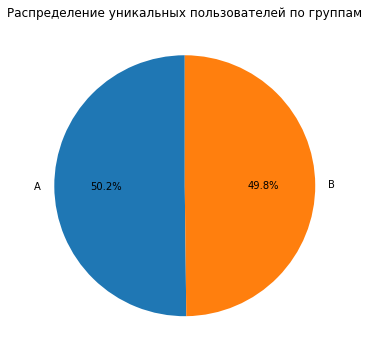

In [18]:
# построим круговую диаграмму для визуализауции соотношения групп А и В
plt.figure(figsize=(6,6))
plt.pie(
    df_test_group['user_id'], 
    labels=df_test_group['test_group'], 
    autopct='%1.1f%%', 
    startangle=90
)
plt.title('Распределение уникальных пользователей по группам')
plt.show()

Группы для тестирования практически равны по количеству.

#### Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [19]:
# проверим пересечение пользователей в группах по идентификатору
a = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id']
b = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id']

intersection = list(set(a) & set(b))
print(intersection) 

[]


Пользователей, которые встречаются одновременно в группах A и B, не выявлено.

In [20]:
# создадим датафрейм, где посчитаем голичество групп для каждого пользователя
df_test_group_1 = (
    sessions_test_part
    .groupby(['user_id'])
    .agg({
        'test_group': 'nunique',
    })
    .reset_index()
)
# выведем пользователей, которые попали в обе выборки
display(df_test_group_1[df_test_group_1['test_group']==2])

,user_id,test_group


#### Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


In [21]:
# создадим датафрейм, в котором отражено разделение на типы устройств внутри группы
df_test_group_device = (
    sessions_test_part
    .groupby(['test_group', 'device'])
    .agg({
        'user_id': 'nunique',
    })
    .reset_index()
)

In [22]:
# посчитаем сумму уникальных пользователей по каждой тестовой группе
group_sums = df_test_group_device.groupby('test_group')['user_id'].transform('sum')

# создадим столбец share как долю в рамках каждой группы
df_test_group_device['share'] = df_test_group_device['user_id'] / group_sums
display(df_test_group_device)

,test_group,device,user_id,share
0,A,Android,656,0.444144
1,A,Mac,156,0.105619
2,A,PC,369,0.249831
3,A,iPhone,296,0.200406
4,B,Android,668,0.455662
5,B,Mac,148,0.100955
6,B,PC,381,0.259891
7,B,iPhone,269,0.183492


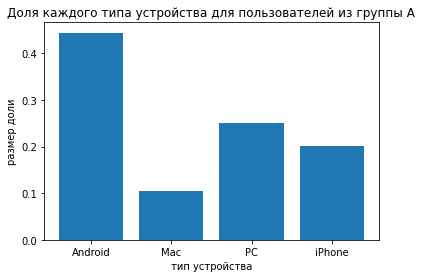

In [23]:
# визуализируем распределение внутри группы А
df_test_group_device_a=df_test_group_device.head(4)
# построим столбчатую диаграмму
x = df_test_group_device_a['device']
y = df_test_group_device_a['share']
             
plt.bar(x, y)
plt.xlabel('тип устройства')
plt.ylabel('размер доли')
plt.title('Доля каждого типа устройства для пользователей из группы A')
plt.show()

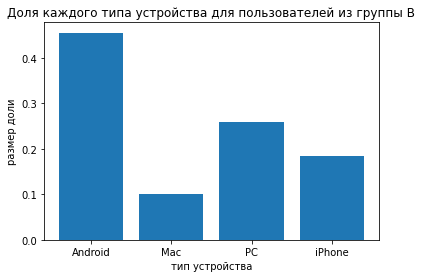

In [24]:
# визуализируем распределение внутри группы В
df_test_group_device_b=df_test_group_device.tail(4)
# построим столбчатую диаграмму
x = df_test_group_device_b['device']
y = df_test_group_device_b['share']
             
plt.bar(x, y)
plt.xlabel('тип устройства')
plt.ylabel('размер доли')
plt.title('Доля каждого типа устройства для пользователей из группы B')
plt.show()

Доли устройств в контрольной и тестовой группах, согласно визуализациям, распределены примерно одинаково.

#### Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


In [25]:
# создадим датафрейм, в котором отражено разделение на регионы внутри группы
df_test_group_region = (
    sessions_test_part
    .groupby(['test_group', 'region'])
    .agg({
        'user_id': 'nunique',
    })
    .reset_index()
)

In [26]:
# посчитаем сумму уникальных пользователей по каждой тестовой группе
group_sums = df_test_group_region.groupby('test_group')['user_id'].transform('sum')

# создадим столбец share как долю в рамках каждой группы
df_test_group_region['share'] = df_test_group_region['user_id'] / group_sums

display(df_test_group_region)

,test_group,region,user_id,share
0,A,CIS,644,0.436019
1,A,EU,224,0.151659
2,A,MENA,609,0.412322
3,B,CIS,645,0.439973
4,B,EU,217,0.148022
5,B,MENA,604,0.412005


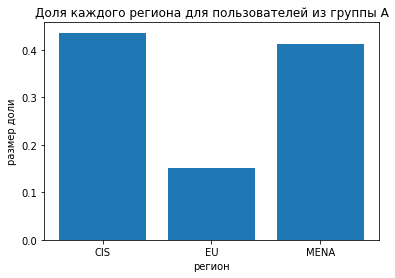

In [27]:
# визуализируем распределение внутри группы А
df_test_group_region_a=df_test_group_region.head(3)
# построим столбчатую диаграмму
x = df_test_group_region_a['region']
y = df_test_group_region_a['share']
             
plt.bar(x, y)
plt.xlabel('регион')
plt.ylabel('размер доли')
plt.title('Доля каждого региона для пользователей из группы A')
plt.show()

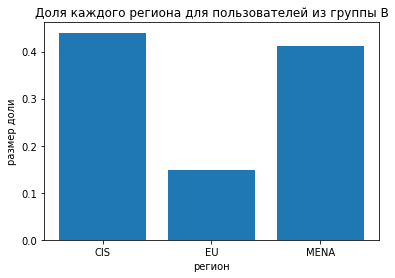

In [28]:
# визуализируем распределение внутри группы В
df_test_group_region_b=df_test_group_region.tail(3)
# построим столбчатую диаграмму
x = df_test_group_region_b['region']
y = df_test_group_region_b['share']
             
plt.bar(x, y)
plt.xlabel('регион')
plt.ylabel('размер доли')
plt.title('Доля каждого региона для пользователей из группы B')
plt.show()

Доли регионов в контрольной и тестовой группах, согласно визуализациям, распределены примерно одинаково.

#### Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Было ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение: корректно ли проходит A/B-тест, или наблюдаются какие-либо нарушения.

------
***Выводы:***

- различие в количестве пользователей между группами А и В составляет 0,74%, что является допустимым значением для проведения теста, так как такое различие не окажет существенного влияния на рузультаты.
- выборки являются независимыми, пользователи в группах не дублируются.
- пользователи тестовой и контрольной групп равномерно распределены по категориальным переменным: устройствам и регионам. 

В первый день какие-либо нарушения в A/B-тесте не наблюдаются.

### Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

####  Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [29]:
# создадим датафрейм sessions_test с историческими данными о сессиях пользователей sessions_project_test.csv
sessions_test=pd.read_csv('/datasets/sessions_project_test.csv')

In [30]:
# создадим новый столбец, заполним его значением 0
sessions_test['good_session']=0
# при выполнении условия "количество сессий >= 4" заполним значением 1
sessions_test.loc[sessions_test['page_counter'] >= 4, 'good_session'] = 1 
# выведем несколько строк для ознакомления
display(sessions_test.head(5))

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

In [31]:
# рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку
df_test_group = (
    sessions_test
    .groupby(['test_group', 'session_date'])
    .agg({
        'session_id': 'nunique',
    })
    .reset_index()
)
display(df_test_group)

,test_group,session_date,session_id
0,A,2025-10-14,1502
1,A,2025-10-15,2235
2,A,2025-10-16,3280
3,A,2025-10-17,4089
4,A,2025-10-18,5013
5,A,2025-10-19,6535
6,A,2025-10-20,5837
7,A,2025-10-21,3927
8,A,2025-10-22,3083
9,A,2025-10-23,2470


In [32]:
# проведем статистический тест, который позволит сделать вывод о равенстве средних двух выборок

metric_a = df_test_group.query("test_group == 'A'")['session_id'].values
metric_b = df_test_group.query("test_group == 'B'")['session_id'].values

alpha = 0.05

stat_welch_ttest, p_value_welch_ttest = ttest_ind(
    metric_a, 
    metric_b, 
    equal_var=False,
    alternative='two-sided'
)
if p_value_welch_ttest>alpha:
    print(f'p-value теста Уэлча ={p_value_welch_ttest}')
    print('Нулевая гипотеза находит подтверждение!')
    print('Интерпретация: количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми')
else:
    print(f'p-value теста Уэлча ={p_value_welch_ttest}')
    print('Нулевая гипотеза не находит подтверждения!')
    print('Интерпретация: количество уникальных дневных сессий в двух выборках различаются или различия статистически значимые')

p-value теста Уэлча =0.9382195854082714
Нулевая гипотеза находит подтверждение!
Интерпретация: количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми


#### Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [33]:
# создадим датафрейм
df_successful_sessions_test = (
    sessions_test
    .groupby(['test_group'])
    .agg({
        'session_id': 'count',
        'good_session': 'sum',
    })
    .reset_index()
)

# посчитаем сумму уникальных пользователей по каждой тестовой группе
group_sums = df_successful_sessions_test.groupby('test_group')['session_id'].transform('sum')

# создадим столбец share как долю в рамках каждой группы
df_successful_sessions_test['share'] = df_successful_sessions_test['good_session'] / group_sums

shares = df_successful_sessions_test.set_index('test_group')['share']

# разницу между долями (A - B). 
diff_AB = round((shares.loc['B'] - shares.loc['A'])*100,1)


display(df_successful_sessions_test)
print (f'Разница между долями успешных сессий для выборок B и A составила {diff_AB}%')

,test_group,session_id,good_session,share
0,A,49551,15248,0.307723
1,B,50454,16059,0.318290


Разница между долями успешных сессий для выборок B и A составила 1.1%


Количество успешных сессий в тестовой выборке примерно на 1.1 процентный пункт выше, чем в контрольной.

####  Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

Для ответа на поставленные вопросы, учитывая, что метрика имеет долевой характер, будем использовать Z-тест пропорций.

In [34]:
# проверим, выполняется ли предпосылка Z-теста пропорций о достаточном размере выборок

n_a, n_b = sessions_test[sessions_test.test_group=='A'].shape[0], sessions_test[sessions_test.test_group=='B'].shape[0] ## размеры выборок A и B
m_a = sessions_test[(sessions_test.test_group=='A')&(sessions_test.good_session==1)].shape[0] # количество успехов (регистраций) в группе A
m_b = sessions_test[(sessions_test.test_group=='B')&(sessions_test.good_session==1)].shape[0] # количество успехов (регистраций) в группе B

p_a, p_b = m_a/n_a, m_b/n_b # рассчитываем доли успехов для каждой группы: A и B

print(f'n_a={n_a}, n_b={n_b}')

print(f'm_a={m_a}, m_b={m_b}')

print(f'p_a={p_a}, p_b={p_b}')

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

n_a=49551, n_b=50454
m_a=15248, m_b=16059
p_a=0.3077233557344958, p_b=0.31828992745867524
Предпосылка о достаточном количестве данных выполняется!


In [35]:
# проведем Z-тест пропорций
alpha = 0.05 
stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller' # так как H_1: p_a < p_b
)
p_value_ztest

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения')

pvalue=0.0001574739988036123 < 0.05
Нулевая гипотеза не находит подтверждения


### Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.
-----
***в каждой выборке приняло участие 41040 пользователей. Рассчитанная длительность A/B-теста при текущем уровене трафика в 9908 пользователей в день составила 9 дней.***

----

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.
-----
***количество успешных сессий в тестовой выборке примерно на 1.1 процентный пункт выше, чем в контрольной***

----

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

---
***pvalue=0.0001574739988036123 < 0.05 (следовательно, на основании текущих данных мы не можем принять нулевую гипотезу, что алгоритм не увеличил долю успешных сессий)***

---

- Стоит ли внедрять нововведение в приложение.

---
***из данных датасета sessions_project_history следует, что значительно уменьшается количество незарегистированных пользовтелей. Из данных датасета sessions_project_test следует, что количество сессий в день также уменьшается. При этом наблюяется статистически значимый рост метрики "доля успешных сессий". Для принятия решения о введении нововведения необходимо проанализировать, являются ли общее количество пользовтаелей и количество сессий барьерными метриками и какая стратеги по заработку денег (предполагается ли отказ от рекламы для незарегистированных пользовтелей и сохранение только пользовтелей с подписками).***

----